In [87]:
import numpy as np

import torch

import matplotlib.pyplot as plt

from tqdm import tqdm
from ray_transforms import get_ray_trafo, get_static_ray_trafo
from test_model_functions_swaped import get_net_corected_operator
# import random
import torch 


import os
from conf import config
from select_model_type_matrix import select_fwd_model_type,select_adj_model_type
from scipy import sparse
from util import get_op,Mat,plots,rand_shift_params,error_for_y,check_path

def im_norm(x):
    x = x.reshape(x.size)
    return np.linalg.norm(x,2)

def sp(a,b):
    return a.reshape(a.size)@b.reshape(b.size)

def ISTA_obj_func(op,y,lam,x):
    return 1/(2*lam)*np.linalg.norm((op(x)-y).reshape(y.size),2)**2+np.linalg.norm(x.reshape(x.size),1)

def Test_PGM(step_op,L,grad_R,true_op,p,y_e,x_0_selector,test_op,mu,num_iter):
    F_abl = lambda x: test_op.adjoint(test_op(x)-y_e) + grad_R(x)
    F_true_abl = lambda x: true_op.adjoint(true_op(x)-y_e) + grad_R(x)
    x = x_0_selector(y_e)
    X = np.zeros((num_iter + 1,x.shape[0],x.shape[1]))
    X[0] = x
    loss = np.zeros(num_iter+1)
    loss[0] = im_norm(p-x)
    TThetaMu = np.zeros(num_iter)
    LL = np.zeros(num_iter)
    AL = np.zeros(num_iter)
    FwL = np.zeros(num_iter)
    AdL = np.zeros(num_iter)
    for i in range(num_iter):
        x_old = x
        x = step_op(x,F_abl(x))
        X[i+1] = x
        loss[i+1] = im_norm(p-x)
        T_Thetamu = (x_old-x)/(mu)
        TThetaMu[i] = im_norm(T_Thetamu)
        LL[i] = L(x_old)-L(x)
        AL[i] = mu*(sp(F_true_abl(x_old)-F_abl(x_old),T_Thetamu)+0.5*TThetaMu[i]**2)
        FwL[i] = im_norm(true_op(x)-test_op(x))
        r = test_op(x)-y_e
        AdL[i] = im_norm(true_op.adjoint(r)-test_op.adjoint(r))
    X = X[np.arange(9,num_iter,10)]
    return {'X':X,'loss':loss,'TThetaMu':TThetaMu,'LL':LL,'AL':AL,'FwL':FwL,'AdL':AdL}

def Test_GD(step_op,L,grad_R,true_op,p,y_e,x_0_selector,test_op,mu,num_iter):
    """_summary_

    Args:
        step_op (_type_): an operator that produces the next iteration x_k+1 = step_op(x_k,F(x_k))
        L (_type_): The objective function that is minimized for testing only
        grad_R (_type_): the differentialle part of the regularization terms
        true_op (_type_): the precise operator we try to achieve
        p (_type_): the phantom
        y_e (_type_): noisy data
        x_0_selector (_type_): function that gives the x_0 deppending on y_e
        test_op (_type_): the operaator we want to test
        adj_test_op (_type_): the adjoint of the test opeartor
        mu (_type_): constant step size for 
        num_iter (_type_): number of iterations taht are being computed

    Returns:
        _type_: _description_
    """ 
    F_abl = lambda x: test_op.adjoint(test_op(x)-y_e) + grad_R(x)
    F_true_abl = lambda x: true_op.adjoint(true_op(x)-y_e) + grad_R(x)
    x = x_0_selector(y_e)
    X = np.zeros((num_iter + 1,x.shape[0],x.shape[1]))
    X[0] = x
    loss = np.zeros(num_iter+1)
    loss[0] = im_norm(p-x)
    TMu = np.zeros(num_iter)
    LL = np.zeros(num_iter)
    AL = np.zeros(num_iter)
    FF = np.zeros(num_iter)
    FwL = np.zeros(num_iter)
    AdL = np.zeros(num_iter)
    for i in range(num_iter):
        x_old = x
        x = step_op(x,F_abl(x))
        X[i+1] = x
        loss[i+1] = im_norm(p-x)
        grad_F = F_true_abl(x_old)
        TMu[i] = im_norm(grad_F)
        LL[i] = L(x_old)-L(x)
        AL[i] = mu*(sp(grad_F,F_abl(x_old))/TMu[i]**2)
        FF[i] = im_norm(F_true_abl(x_old)-F_abl(x_old))
        FwL[i] = im_norm(true_op(x)-test_op(x))
        r = test_op(x)-y_e
        AdL[i] = im_norm(true_op.adjoint(r)-test_op.adjoint(r))
    X = X[np.arange(9,num_iter,10)]
    return {'X':X,'loss':loss,'TMu':TMu,'LL':LL,'AL':AL,'FF':FF,'FwL':FwL,'AdL':AdL}

def save_plot_Test(path,dic,background = {},show = False):
    fig,axs = plots(2,1,3/2)
    axs[0].set_title('reconstruction loss')
    axs[0].plot(background.get('static',[]),label = 'static')
    axs[0].plot(background.get('true',[]),label = 'true')
    axs[0].plot(dic.get('loss',[]),label = 'cor')
    axs[0].set_yscale('log')
    axs[0].legend()
    axs[1].set_title('alignement')
    axs[1].plot(dic.get('LL')/dic.get('TM')**2,label='LL')
    axs[1].plot(dic.get('AL')/dic.get('TM')**2,label='AL')
    axs[1].set_yscale('log')
    axs[1].legend()
    fig.savefig(path)
    if show:
        plt.show(fig)
    else:
        plt.close(fig)

class net_cor_op():
    def __init__(self,static_op,fw_model,fw_swaped,adjoint_model,adj_swaped,device) -> None:
        """creates a operator 

        Args:
            static_op (_type_): _description_
            fw_model (_type_): _description_
            fw_swaped (_type_): _description_
            adjoint_model (_type_): _description_
            adj_swaped (_type_): _description_
            device (_type_): _description_
        """
        self.cor_op = get_net_corected_operator(static_op, fw_model,device = device,swaped=fw_swaped)
        self.cor_adj_op = get_net_corected_operator(static_op.adjoint, adjoint_model,device = device,swaped=adj_swaped)
    def __call__(self, x) -> np.array:
        """returns the forward operator

        Args:
            x (_type_): _description_

        Returns:
            np.array: _description_
        """
        return self.cor_op(x)
    def adjoint(self, x) -> np.array:
        """returns the adjoint of the opearator

        Args:
            x (_type_): _description_

        Returns:
            np.array: _description_
        """
        return self.cor_adj_op(x)

def soft_shrink(x,alpha):
    """the soft shrinkige operator
    Args:
        x (np.array): input
        alpha ( float ): parameter

    Returns:
        np.array: soft_schrink(x)
    """
    return np.sign(x) * np.maximum(np.abs(x)-alpha,0)
    


In [ ]:
np.cos(60/(2*np.pi))

: 

In [69]:
gpu_idx = 0
device = f"cuda:{gpu_idx}" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
import astra
astra.set_gpu_index(gpu_idx)

Using cuda:0 device


In [70]:
A_static_s = sparse.load_npz('Matritzen/64_64_256_96_static.npz')
x_res = 64
y_res = 64
num_angles = 256
detector_points = 96
static_op = get_op(A_static_s,x_res, y_res, num_angles, detector_points)
static_ray_trafo = get_static_ray_trafo(x_res, y_res,num_angles,detector_points,detector_len=2)

In [71]:
tp = np.load(file='phantoms/test_phantoms_64_1.npy')
p = tp[0,:,:]
p.shape

(64, 64)

In [72]:
def x_0is0(y):
    return np.zeros((x_res,y_res))
def x_0isATy(y):
    return static_op.adjoint(y)
def x_0isp(y):
    return p

In [73]:
runs_list = ['Test']
operator_list = []
op_name_list = []
i = 10
A_u = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/u_ray_trafo_{i}.npz")
u_op = get_op(A_u,x_res, y_res, num_angles, detector_points)
operator_list.append(u_op)
op_name_list.append(r'$n=1$, $u$ shift')
A_v = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/v_ray_trafo_{i}.npz")
v_op = get_op(A_v,x_res, y_res, num_angles, detector_points)
operator_list.append(u_op)
op_name_list.append(r'$n=1$, $v$ shift')
A_u_v = sparse.load_npz(f"Matritzen/64_64_256_96_1_u_and_v_shift/u_v_ray_trafo_{i}.npz")
u_v_op = get_op(A_u_v,x_res, y_res, num_angles, detector_points)
operator_list.append(u_op)
op_name_list.append(r'$n=1$, $u$ and $v$ shift')
shift_params = np.load(f'Matritzen/64_64_256_96_1_u_and_v_shift/shift_params_{i}.npy')

A_s = sparse.load_npz('Matritzen/Test_ray_trafo_64_256_96_100.npz')
operator_list.append(get_op(A_s,x_res, y_res, num_angles, detector_points))
op_name_list.append(r'$n=1$, $u$ and $v$ shift, new')
A_s = sparse.load_npz('Matritzen/64_64_256_96_strong_u_v_shift.npz')
operator_list.append(get_op(A_s,x_res, y_res, num_angles, detector_points))
op_name_list.append(r'$n=1$, $u$ and $v$ shift, new large amplitude')
A_s = sparse.load_npz("Matritzen/Test_64_256_96_5addet_u_v.npz")
operator_list.append(get_op(A_s,x_res, y_res, num_angles, detector_points))
op_name_list.append(r'$n=5$, $u$ and $v$ shift, new')

In [74]:
import odl
R = odl.solvers.Huber(static_ray_trafo.domain,0.001)
grad_R = lambda x :R.gradient(x).asarray()


In [9]:
c = config('Test')

In [75]:
os.listdir('./runs/')

['Test',
 'run_20220828_matrix_ISTA',
 'run_20220828_matrix_ISTA_2',
 'run_20220829_matrix_ISTA',
 'run_20220830_matrix_ISTA',
 'run_20220830_matrix_GD',
 'run_20220831_matrix_GD',
 'run_20220826_matrix_ISTA',
 'run_20220901_matrix_ISTA',
 'run_20220902_matrix_ISTA',
 'run_20220902_matrix_ISTA_2',
 'run_20220902_matrix_ISTA_3',
 'run_20220903_matrix_ISTA',
 'run_20220904_matrix_ISTA',
 'run_20220904_matrix_ISTA_2',
 'run_20220905_matrix_ISTA',
 'run_20220905_matrix_ISTA_2',
 'run_20220906_matrix_GD',
 'run_20220908_matrix_ISTA',
 'run_20220912_matrix_ISTA',
 'run_20220913_matrix_ISTA',
 'run_20220822_matrix_ISTA',
 'run_20220823_matrix_ISTA',
 'run_20220824_matrix_ISTA',
 'run_20220825_matrix_ISTA']

In [76]:
save_path = './eval_dictionaries/'
check_path(save_path)

In [77]:
runs_list = ['run_20220822_matrix_ISTA',
 'run_20220823_matrix_ISTA',
 'run_20220824_matrix_ISTA',
 'run_20220825_matrix_ISTA',
 'run_20220826_matrix_ISTA',
 'run_20220902_matrix_ISTA_2']

In [184]:
num_iter = 100
for i,op in enumerate(operator_list):
    y_e = error_for_y(op(p),e_p=0.01)
    op_name = op_name_list[i]
    ### ISTA ###
    L = lambda x :1/(2*lam)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+np.linalg.norm(x.reshape(x.size),1)
    mu = 0.0002
    lam = 0.001 
    step_op = lambda x,grad_F_x : soft_shrink(x-mu/lam*grad_F_x,mu)
    Zero = lambda x: np.zeros_like(x)
    params = f'mu{mu}lam{lam}'.replace('.','_')
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,op,mu,num_iter)
    np.save(save_path+'true_'+op_name + params+'_ISTA' +'_x_0adj',dic)
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0is0,op,mu,num_iter)
    np.save(save_path+'true_'+op_name + params+'_ISTA' +'_x_00',dic)
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isp,op,mu,num_iter)
    np.save(save_path+'true_'+op_name+ params+'_ISTA' +'_x_0p',dic)
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,static_op,mu,num_iter)
    np.save(save_path+'static_'+ op_name+ params+'_ISTA' +'_x_0adj',dic)
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0is0,static_op,mu,num_iter)
    np.save(save_path+'static_'+ op_name+ params+'_ISTA' +'_x_00',dic)
    dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isp,static_op,mu,num_iter)
    np.save(save_path+'static_'+ op_name+ params+'_ISTA' +'_x_0p',dic)
    

    # L = lambda x :1/(2)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+lam*np.linalg.norm(x.reshape(x.size),1)
    # mu = 0.2
    # lam = 0.001 
    # step_op = lambda x,grad_F_x : soft_shrink(x-mu*grad_F_x,lam*mu)
    # Zero = lambda x: np.zeros_like(x)
    
    # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,op,mu,num_iter)
    # np.save(save_path+'true_'+op_name+ params+'_ISTAlam' +'_x_0adj',dic)
    # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0is0,op,mu,num_iter)
    # np.save(save_path+'true_'+op_name+ params+'_ISTAlam' +'_x_00',dic)
    # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isp,op,mu,num_iter)
    # np.save(save_path+'true_'+op_name+ params+'_ISTAlam' +'_x_0p',dic)
    # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,static_op,mu,num_iter)
    # np.save(save_path+'static_'+ op_name+ params+'_ISTAlam' +'_x_0adj',dic)
    # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0is0,static_op,mu,num_iter)
    # np.save(save_path+'static_'+ op_name+ params+'_ISTAlam' +'_x_00',dic)
    # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isp,static_op,mu,num_iter)
    # np.save(save_path+'static_'+ op_name+ params+'_ISTAlam' +'_x_0p',dic)

            
    # L = lambda x :1/(2)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+lam*np.linalg.norm(x.reshape(x.size),1)
    # mu = 0.2
    # lam = 0.001
    # step_op = lambda x,grad_F_x : x-mu*(grad_F_x+lam*grad_R(x))
    
    # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0isATy,op,mu,num_iter)
    # np.save(save_path+'true_'+op_name+ params+'_GD_Huber' +'_x_0adj',dic)
    # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0is0,op,mu,num_iter)
    # np.save(save_path+'true_'+op_name+ params+'_GD_Huber' +'_x_00',dic)
    # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0isp,op,mu,num_iter)
    # np.save(save_path+'true_'+op_name+ params+'_GD_Huber' +'_x_0p',dic)
    # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0isATy,static_op,mu,num_iter)
    # np.save(save_path+'static_'+ op_name+ params+'_GD_Huber' +'_x_0adj',dic)
    # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0is0,static_op,mu,num_iter)
    # np.save(save_path+'static_'+ op_name+ params+'_GD_Huber' +'_x_00',dic)
    # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0isp,static_op,mu,num_iter)
    # np.save(save_path+'static_'+ op_name+ params+'_GD_Huber' +'_x_0p',dic)
        
    for run in runs_list:
        c = config(run)

        TA_static_s = torch.sparse_csr_tensor(A_static_s.indptr,A_static_s.indices,A_static_s.data,A_static_s.shape,dtype=float)
        fw_model = select_fwd_model_type(c,TA_static_s.to_dense().to(device))
        AT_static_s = sparse.csr_matrix(A_static_s.T)
        TAT_static_s = torch.sparse_csr_tensor(AT_static_s.indptr,AT_static_s.indices,AT_static_s.data,AT_static_s.shape,dtype=float)
        adj_model = select_adj_model_type(c,TAT_static_s.to_dense().to(device))
        a = '_iter_49'#'last'#'iter_46'
        fw_model.load_state_dict(torch.load(c.model_path + 'model' + a,map_location=device))
        adj_model.load_state_dict(torch.load(c.model_path + 'adjoint_model' + a,map_location=device))
        fw_model = fw_model.to(device)
        adj_model = adj_model.to(device)
        cor_op = net_cor_op(static_op,fw_model,c.forward_swaped,adj_model,c.adj_swaped,device)
    
        ### ISTA ###
        L = lambda x :1/(2*lam)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+np.linalg.norm(x.reshape(x.size),1)
        mu = 0.0002
        lam = 0.001 
        step_op = lambda x,grad_F_x : soft_shrink(x-mu/lam*grad_F_x,mu)
        Zero = lambda x: np.zeros_like(x)
        dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,cor_op,mu,num_iter)
        np.save(save_path+run+'_'+op_name+ params+'_ISTA' +'_x_0adj',dic)
        dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0is0,cor_op,mu,num_iter)
        np.save(save_path+run+'_'+op_name+ params+'_ISTA' +'_x_00',dic)
        dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isp,cor_op,mu,num_iter)
        np.save(save_path+run+'_'+op_name+ params+'_ISTA' +'_x_0p',dic)

        

        # L = lambda x :1/(2)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+lam*np.linalg.norm(x.reshape(x.size),1)
        # mu = 0.2
        # lam = 0.001 
        # step_op = lambda x,grad_F_x : soft_shrink(x-mu*grad_F_x,lam*mu)
        # Zero = lambda x: np.zeros_like(x)
        # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isATy,cor_op,mu,num_iter)
        # np.save(save_path+run+'_'+op_name+ params+'_ISTAlam' +'_x_0adj',dic)
        # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0is0,cor_op,mu,num_iter)
        # np.save(save_path+run+'_'+op_name+ params+'_ISTAlam' +'_x_00',dic)
        # dic = Test_PGM(step_op,L,Zero,op,p,y_e,x_0isp,cor_op,mu,num_iter)
        # np.save(save_path+run+'_'+op_name+ params+'_ISTAlam' +'_x_0p',dic)


                
        # L = lambda x :1/(2)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+lam*np.linalg.norm(x.reshape(x.size),1)
        # mu = 0.2
        # lam = 0.001
        # step_op = lambda x,grad_F_x : x-mu*(grad_F_x+lam*grad_R(x))
        # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0isATy,cor_op,mu,num_iter)
        # np.save(save_path+run+'_'+op_name+ params+'_GD_Huber' +'_x_0adj',dic)
        # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0is0,cor_op,mu,num_iter)
        # np.save(save_path+run+'_'+op_name+ params+'_GD_Huber' +'_x_00',dic)
        # dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0isp,cor_op,mu,num_iter)
        # np.save(save_path+run+'_'+op_name+ params+'_GD_Huber' +'_x_0p',dic)

        
        

In [45]:
dic = np.load('./eval_dictionaries/run_20220822_matrix_ISTA_$n=1$, $u$ and $v$ shift, new large amplitude_GD_Huber_x_00.npy',allow_pickle=True).item()

In [41]:
l=[]
for i in range(22,27):
    l.append(f'08{i}')
l

['0822', '0823', '0824', '0825', '0826']

In [ ]:
for dic_path in os.listdir(save_path):

    if not dic_path.startswith('static') and not dic_path.startswith('true') and dic_path.startswith('run_20220822_matrix_ISTA'):
        
        fig,axs = plots(2,4,1,10)
        fig.suptitle(rf'{dic_path.split("run_20220822_matrix_ISTA_")[1].replace("_"," ")}')
        
        static_dic=dic = np.load(save_path+'static' +dic_path.split('run_20220822_matrix_ISTA')[1],allow_pickle=True).item()
        true_dic=dic = np.load(save_path+'true'+dic_path.split('run_20220822_matrix_ISTA')[1],allow_pickle=True).item()
        axs[1,1].set_title('static operator')
        axs[1,1].imshow(static_dic.get('X')[-1])
        axs[1,2].set_title('precise operator')
        axs[1,2].imshow(true_dic.get('X')[-1])
        axs[1,0].plot(static_dic.get('loss'),label='static_op')
        axs[1,0].plot(true_dic.get('loss'),label='precise operator')
        for i,n in enumerate(['0822', '0823', '0824', '0825']):
            dic = np.load(save_path+dic_path.split('0822')[0] +n + dic_path.split('0822')[1],allow_pickle=True).item()
            axs[0,i].imshow(dic.get('X')[-1])
            axs[0,i].set_title(n)
            axs[1,0].plot(dic.get('loss'),label=n)
        axs[1,0].legend()

In [ ]:
for dic_path in os.listdir(save_path):

    if not dic_path.startswith('static') and not dic_path.startswith('true') and dic_path.startswith('run_20220822_matrix_ISTA')  and '_ISTA_x_0' in dic_path:
        
        fig,axs = plots(2,4,1,4)
        fig.suptitle(rf'{dic_path.split("run_20220822_matrix_ISTA_")[1].replace("_"," ")}')
        
        static_dic=dic = np.load(save_path+'static' + dic_path.split('run_20220822_matrix_ISTA')[1],allow_pickle=True).item()
        true_dic=dic = np.load(save_path+'true'+dic_path.split('run_20220822_matrix_ISTA')[1],allow_pickle=True).item()
        axs[1,1].set_title('static operator')
        axs[1,1].imshow(static_dic.get('X')[-1])
        axs[1,2].set_title('precise operator')
        axs[1,2].imshow(true_dic.get('X')[-1])
        axs[1,3].set_title('original')
        axs[1,3].imshow(p)
        axs[1,0].plot(static_dic.get('loss'),label='static_op')
        axs[1,0].plot(true_dic.get('loss'),label='precise operator')
        for i,n in enumerate(['0822', '0823', '0824', '0825']):
            m = [r'cor. before ops',r'cor in $X$',r'cor.after ops',r'cor in $Y$'][i]
            dic = np.load(save_path+dic_path.split('0822')[0] +n + dic_path.split('0822')[1],allow_pickle=True).item()
            axs[0,i].imshow(dic.get('X')[-1])
            axs[0,i].set_title(m)
            axs[1,0].plot(dic.get('loss'),label=m)
        axs[1,0].legend()
        axs[1,0].set_yscale('log')
        fig.set_dpi(300)
        fig.savefig('./Bilder/'+ dic_path.split('.npy')[0].replace(',','').replace('$','').replace(' ','_').replace('=','') +'.png')
        plt.show(fig)





In [177]:

dic_path

'run_20220902_matrix_ISTA_2_$n=5$, $u$ and $v$ shift, new_GD_Huber_x_0p.npy'

In [38]:
a.split('0826')[0] + '0822'+ a.split('0826')[1]

'run_20220822_matrix_ISTA_$n=5$, $u$ and $v$ shift, new_GD_Huber_x_0p_static'

In [47]:
a.replace('_',' ')

'run 20220826 matrix ISTA $n=5$, $u$ and $v$ shift, new GD Huber x 0p static'

In [45]:
a.split('run_20220826_matrix_ISTA_')[1]

'$n=5$, $u$ and $v$ shift, new_GD_Huber_x_0p_static'

In [37]:
np.zeros((3, (2,2)[0],(2,2)[1]))

array([[[ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.]],

       [[ 0.,  0.],
        [ 0.,  0.]]])

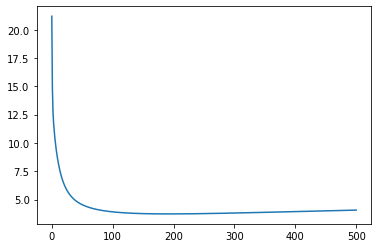

In [145]:
L = lambda x :1/(2)*np.linalg.norm((op(x)-y_e).reshape(y_e.size),2)**2+lam*np.linalg.norm(x.reshape(x.size),1)
mu = 0.2
lam = 0.0001
y_e = error_for_y(op(p),e_p=0.01)
step_op = lambda x,grad_F_x : soft_shrink(x-mu*(grad_F_x+lam*64*grad_R(x)),mu*lam)

dic = Test_GD(step_op,L,Zero,op,p,y_e,x_0is0,static_op,mu,num_iter=500)
plt.plot(dic.get('loss'))

In [14]:
50*40/60

33.333333333333336

In [84]:
Z = np.ones((100,2,2))

In [85]:
Z[np.arange(9,100,10)]

array([[[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]],

       [[ 1.,  1.],
        [ 1.,  1.]]])